# 2018 Mendocino Complex Fire: Fire Scar and Land Cover Statistics

Author: Haylee Oyler

### About

This notebook explores the 2018 [Mendocino Complex Fire](https://en.wikipedia.org/wiki/Mendocino_Complex_Fire) that occurred in Mendocino County, California. The complex was composed of the River Fire and the Ranch Fire, both of which burned 198 km<sup>2</sup> (48,920 acres) and 1,660 km<sup>2</sup> (410,203 acres) respectively for a total of 1,858 km<sup>2</sup> (459,123 acres) burned. At the time, it was the largest fire in California's recorded history. Fires that exceed 100 km<sup>2</sup> are known as megafires because they greatly surpass the severity and size of historical wildfires. As climate change and land use change intensify wildfire risk, megafires are expected to increase in frequency.

I chose region in particular because my first paper with Dr. Kendall Calhoun and Dr. Justin Brashares was conducted in this region at the [Hopland Research and Extension Center](https://ucanr.edu/rec/hopland-research-and-extension-center). We studied the effects of fire on wildlife recovery, specifically using audio monitors to examine the distribution of bird and bat communities across different levels of fire severity and pyrodiversity. The paper itself can be found [here](https://doi.org/10.1002/ecs2.70263).

### Overview
This code will use the Mendocino Complex Fire as a case study to explore different metrics of fire severity, recovery, and projected risk. Specifically, it uses:

- Landsat data to visualize true and false color imagery of the fire scar and the relative burn ratio 
- Land use and land cover data from the USGS to calculate land cover statistics within the fire perimeter boundaries
- Downscaled climate projection data from Cal-Adapt to view wildfire-relevant projected climate variables in California

### Data
-   [CalFire Fire Perimeter Data](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters): The Ranch Fire perimeter data comes from CalFire's data portal. The accessed GeoDatabase includes information on the fire date, managing agency, cause, acres, and the geospatial boundary of the fire, among other information. This data was pre-processed to select only the Ranch fire boundary geometry.

-   [Landsat Data](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2): The Landsat data comes from Microsoft's Planetary Computer Data Catalog. It is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data, collected by the Landsat 8 satellite. 

- [Land Use and Land Cover Data](https://planetarycomputer.microsoft.com/dataset/gap#overview): The LULC data comes from Microsoft's Planetary Computer Data Catalog. Specifically, the Gap Collection provided by the United States Geological Survey. It is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. 

- [Climate Data](https://analytics.cal-adapt.org/data/): The climate projection data comes from Cal-Adapt's Analytics Engine Data Catalog. This catalog contains downscaled data from many global climate models. Dynamical downscaling was conducted by UCLA with the [Weather and Research Forecast](https://en.wikipedia.org/wiki/Weather_Research_and_Forecasting_Model) model. Statistical downscaling was conducted by the Scripps Institute of Oceanography using [Localized Constructed Analogs version 2](https://loca.ucsd.edu/)


#### *References*
-   California Department of Forestry and Fire Protection (CAL FIRE), calfire_all.gdb, 2024-11-17, retrieved from [CAL FIRE data portal.](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters)
-   Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6
-   A. Davidson and A. McKerrow, “GAP/LANDFIRE National Terrestrial Ecosystems 2011.” U.S. Geological Survey, 2016. doi: 10.5066/F7ZS2TM0. Available: https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5. [Accessed: Nov. 26, 2024]
-   Cal-Adapt. (2018). LOCA Derived Data [GeoTIFF]. Data derived from LOCA Downscaled CMIP5 Climate Projections. Retrieved from https://cal-adapt.org/. 



In [2]:
# Load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches 
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr
from shapely import box
from IPython.display import Image 
import scipy.stats as stats
import rasterio
from rasterio.plot import show

# MPC 
import pystac_client
import planetary_computer
import odc.stac
from pystac.extensions.eo import EOExtension as eo
from pystac.extensions.projection import ProjectionExtension

# Cal-Adapt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point


## Fire Scar Visualization

We'll start by accessing the MPC data catalog to retrieve the Landsat data. We want to narrow down our region of interest to the bounding box of the Ranch Fire, so we'll import the fire perimeter data and extract the necessary coordinates for our query.

In [3]:
# Import Ranch Fire perimeter
ranch_fire = gpd.read_file(os.path.join('data', 'ranch_boundary.geojson'))
river_fire = gpd.read_file(os.path.join('data', 'river_boundary.geojson'))

# Combine the two fire perimeters into one complex fire
union_geom = ranch_fire.geometry.union(river_fire.geometry)

# Create a new geo dataframe of the combined geometry
mendocino = gpd.GeoDataFrame(geometry=[union_geom.unary_union], 
                            crs=ranch_fire.crs)

# Get the bounding box of the entire complex fire
mendocino_bbox = list(mendocino.to_crs('epsg:4326').total_bounds)

# Set time period of interest
time_of_interest = "2018-10-01/2018-11-01"

In [4]:
# Open MPC data catalog connection
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

# Search MPC catalog 
search = catalog.search(collections=['landsat-c2-l2'],
                        datetime=time_of_interest,
                        bbox=mendocino_bbox,
                        query={
                            # Images with less than 10% cloud cover
                            "eo:cloud_cover": {"lt": 10},
                            # Landsat 8 and 9 were chosen to avoid landsat 7 data collection failure
                            "platform": {"in": ["landsat-8", "landsat-9"]}
                            }
                        )

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 4 Items


In [5]:
# Select the item with the minimum cloud cover
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

# Display item 
print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_045033_20181030_02_T1 from 2018-10-30 with 0.02% cloud cover


In [6]:
# Select bands of interest for visualization
bands_of_interest = ["nir08", "red", "green", "blue", "swir16", "swir22"]

# Load in the data from the stac item
post_burn_data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=mendocino_bbox
).isel(time=0)

# Reproject data to match the CRS between our two datasets
mendocino= mendocino.to_crs("EPSG:4326")
post_burn_data = post_burn_data.rio.reproject("EPSG:4326")

# Confirm that the CRS of our data match
assert post_burn_data.rio.crs == mendocino.crs

Now that our data input and output is complete, we'll create a simple map of the true color and false color imagery of the fire scar

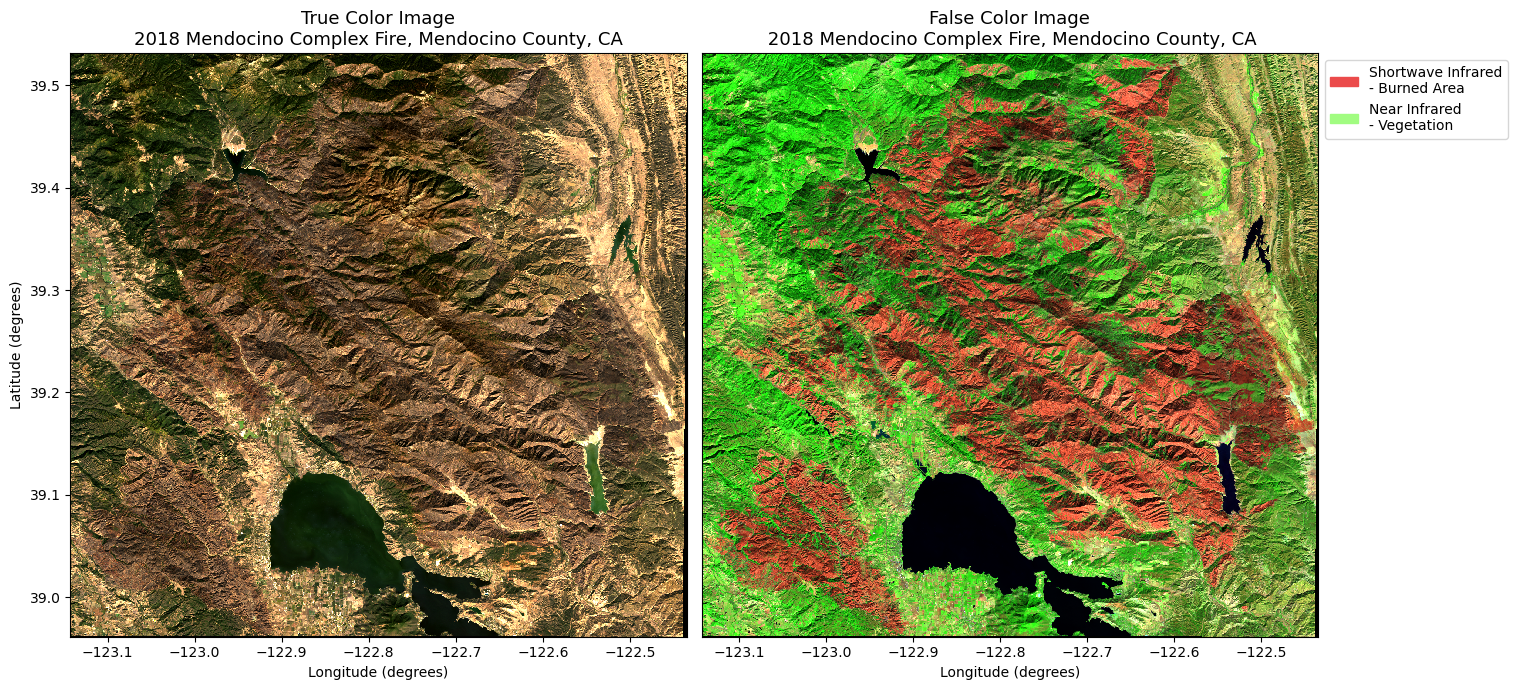

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# True color image
post_burn_data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=axes[0])

# Set titles and labels
axes[0].set_title("True Color Image\n2018 Mendocino Complex Fire, Mendocino County, CA", fontsize=13)
axes[0].set_xlabel('Longitude (degrees)')
axes[0].set_ylabel('Latitude (degrees)')

# False color image
post_burn_data[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=axes[1], robust=True)

# Create a legend for the bands and boundary
legend_swir = mpatches.Patch(color="#eb4b4b", label='Shortwave Infrared\n- Burned Area')
legend_nir = mpatches.Patch(color="#a1fc81", label='Near Infrared\n- Vegetation')

# Add legend to false color subplot
axes[1].legend(handles=[legend_swir, legend_nir], 
                bbox_to_anchor=(1.32, 1), 
                fontsize=10)

# Set title and labels
axes[1].set_title('False Color Image\n 2018 Mendocino Complex Fire, Mendocino County, CA', fontsize=13)
axes[1].set_xlabel('Longitude (degrees)')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

### Fire Severity: NBR and RBR

While images like the ones above are a great starting point for visualizing fire severity, there are many other ways to understand changing land cover as a result of fire. Two common ones are the [normalized burn ratio](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio) and the [relative burn ratio](https://www.mdpi.com/2072-4292/6/3/1827). The normalized burn ratio uses the spectral reflectance of healthy and burned vegetation to identify areas of high severity fire. Near infrared radiation ($NIR$) is highly reflective in healthy vegetation and short wave infrared ($SWIR$) is highly reflective in unhealthy or burned vegetation.

$$ NBR = \frac{NIR - SWIR}{NIR + SWIR} $$

The relative burn ratio is an alternate way to visualize fire severity that takes into account the overall variation in vegetation before the fire event. Scaling by pre-fire conditions allows you to compare vegetation loss across different intital vegetation conditions. Here's how it is described in [Parks et al. 2014](https://www.mdpi.com/2072-4292/6/3/1827):"*Simply put, RBR is the dNBR divided by a simple adjustment to the pre-fire NBR. Adding 1.001 to the denominator ensures that the denominator will never be zero, thereby preventing the equation from reaching infinity and failing.*"

$$ RBR = \frac{\delta NBR}{NBR_{prefire} + 1.001} $$

For this visualization, I will be creating a map of $RBR$ for the Ranch Fire. To do this, will need to get data before the fire event to analyze pre-fire conditions. 

In [8]:
# Change our time period of interest to before the fire
time_of_interest = "2018-01-01/2018-07-01"

# Search MPC catalog 
search = catalog.search(collections=['landsat-c2-l2'],
                        datetime=time_of_interest,
                        bbox=mendocino_bbox,
                        query={
                            # Images with less than 10% cloud cover
                            "eo:cloud_cover": {"lt": 10},
                            # Landsat 8 and 9 were chosen to avoid landsat 7 data collection failure
                            "platform": {"in": ["landsat-8", "landsat-9"]}
                            }
                        )

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")

# Select the item with the minimum cloud cover
pre_burn_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {pre_burn_item.id} from {pre_burn_item.datetime.date()}"
    + f" with {pre_burn_item.properties['eo:cloud_cover']}% cloud cover"
)

# Select bands of interest for visualization
bands_of_interest = ["nir08", "red", "green", "blue", "swir16", "swir22"]
pre_burn_data = odc.stac.stac_load(
    [pre_burn_item], bands=bands_of_interest, bbox=mendocino_bbox
).isel(time=0)

# Confirm CRS matches the post-burn data
pre_burn_data = pre_burn_data.rio.reproject("EPSG:4326")
assert post_burn_data.rio.crs == pre_burn_data.rio.crs

Returned 12 Items
Choosing LC08_L2SP_045033_20180507_02_T1 from 2018-05-07 with 0.04% cloud cover


In [9]:
# Pre-burn NBR
pre_swir = pre_burn_data["swir22"].astype("float")
pre_nir = pre_burn_data["nir08"].astype("float")
pre_nbr = (pre_nir - pre_swir) / (pre_nir + pre_swir)

# Post-burn NBR
post_swir = post_burn_data["swir22"].astype("float")
post_nir = post_burn_data["nir08"].astype("float")
post_nbr = (post_nir - post_swir) / (post_nir + post_swir)

# Difference in NBR
dnbr =  pre_nbr - post_nbr

# Relative burn ratio
rbr = dnbr / (pre_nbr + 1.001)

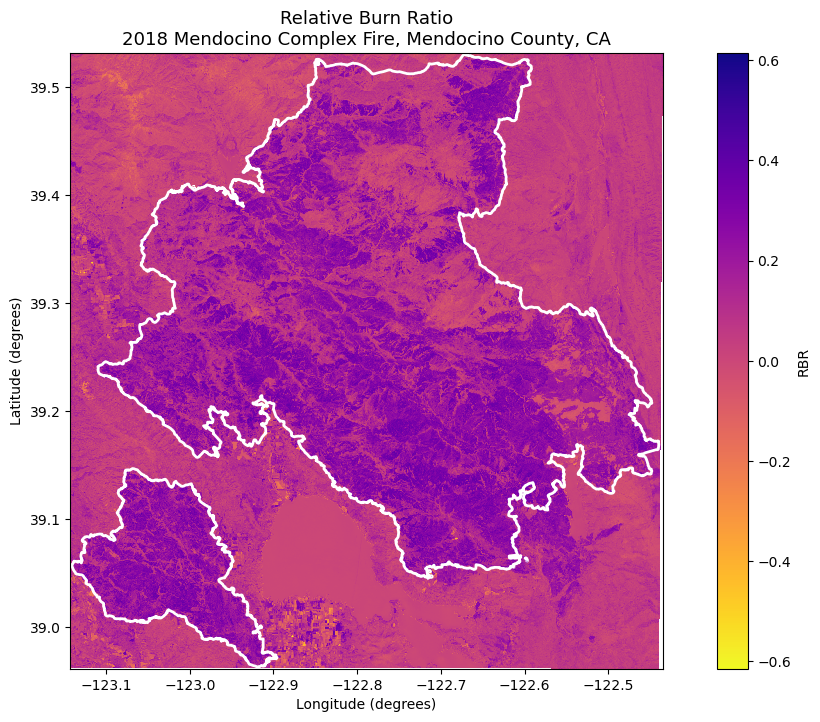

In [10]:
# View RBR across the fire scar 
fig, ax = plt.subplots(figsize=(14, 8))

rbr.plot.imshow(ax=ax, cmap="plasma_r",
                    cbar_kwargs={
                        'label':'RBR',
                    })

# Plot the fire perimeter
mendocino.boundary.plot(ax=ax, edgecolor='#fff', 
                        linewidth=2, label='Mendocino Complex Fire Boundary')

ax.set_title("Relative Burn Ratio\n2018 Mendocino Complex Fire, Mendocino County, CA", fontsize=13)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
plt.show()

Both the false color imagery and the $RBR$ imagery provide ways to understand the scope and magnitude of fire across landscapes. But what if you were interested in understanding more detail about the area affected? For this, we'll turn to data on **land cover**.

## Land Cover Statistics

To understand what biomes and land cover types were affected by the fire, we'll access a different MPC collection: the [USGS Gap Land Cover data](https://www.usgs.gov/programs/gap-analysis-project/science/land-cover-vision). This data contains information on detailed information on land use and land cover (lulc) types that will let us get more information about the Mendocino Complex Fire's impact. One downside of this dataset is that it is from 2011, so it is fairly outdated. It also means we cannot compare land cover before and after the fire event in the same way as with the Landsat data. The biggest upside of the Gap collection, however, is its level of detail. This dataset contains much more finescale classification of land cover and land use types than some of the more general datasets present in the MPC catalog. So, for this example, we will use the Gap data to make an estimation of what the land cover was like in Mendocino County before the 2018 fire.

In [11]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog 
search = catalog.search(collections=['gap'], # Different collection than previous catalog search
                        bbox=mendocino_bbox)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 1 Items


Note that only one item was returned because the Gap collection only contains data from the 2011 sampling efforts

In [12]:
# Select unique search item
item = items[0]  

# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)

# Remove length 1 dimension (band)
lulc = lulc.squeeze().drop_vars('band')
print("Sizes of dimensions:", dict(lulc.sizes))

# Confirm CRS match
lulc = lulc.rio.reproject("EPSG:4326")
assert lulc.rio.crs == mendocino.crs

Sizes of dimensions: {'y': 10000, 'x': 10000}


In [13]:
# Access the colormap associated with the Gap data
with rasterio.open(item.assets["data"].href) as dataset:
    colormap = dataset.colormap(1)

# Extract the colormap keys, these correspond to a land cover class
keys = list(colormap.keys()) 
keys.sort()

# Confirm that every unique color map key was extracted
assert keys == list(range(0, len(keys)))  

# Convert colors to RGBA format that works with matplotlib 
color_list = []
for key in keys:  
    rgba = colormap[key] 
    # Rasterio colors are 0-255 but matplotlob needs 0-1 
    normalized_color = [float(v) / float(255) for v in rgba]
    color_list.append(normalized_color)

# Create a discrete colormap from the converted colors
cmap = ListedColormap(color_list)


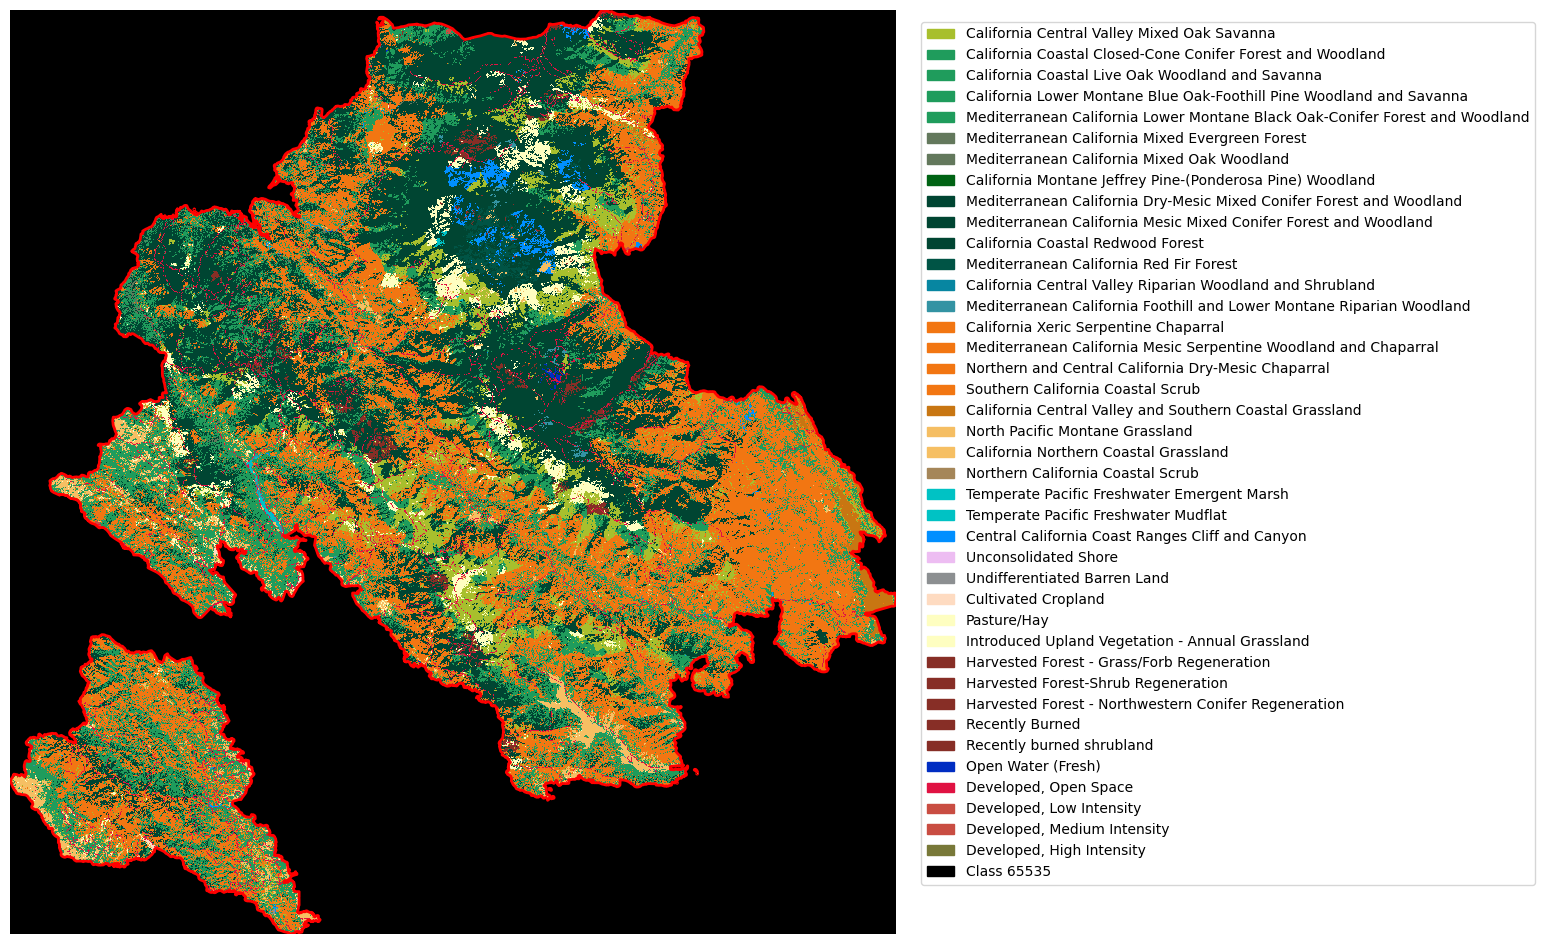

In [14]:
# Clip to fire perimeter
lulc_clipped = lulc.rio.clip(mendocino.geometry, drop=True)

# Extract values from the clipped data
lulc_data = lulc_clipped.values

# Get unique values
unique_values = np.unique(lulc_data)
# unique_values = unique_values[unique_values != 0]  # Remove no-data

# Create a subset colormap and class labels for values in clipped data
subset_colors = [cmap.colors[v] for v in unique_values]
subset_cmap = ListedColormap(subset_colors)

classes = item.properties["label:classes"][0]["classes"]

# Create patches for clipped data
patches = []
for i, v in enumerate(unique_values):
    if v < len(classes):
        patches.append(Patch(color=subset_colors[i], label=classes[v]))
    else:
        patches.append(Patch(color=subset_colors[i], label=f'Class {v}'))

# Initialize figure
fig, ax = plt.subplots(figsize=(13, 12))
ax.set_axis_off()

# Map the clipped data values to the subset colormap indices
mapped_data = np.zeros_like(lulc_data)
for i, v in enumerate(unique_values):
    mapped_data[lulc_data == v] = i

# Convert mapped data to color array for visualization
color_data = np.moveaxis(
    subset_cmap(mapped_data), [0, 1, 2], [1, 2, 0]
)

# Plot the data using rasterio.show
_ = show(color_data, ax=ax, transform=lulc_clipped.rio.transform(), interpolation="none")

# Add the fire boundary
mendocino.boundary.plot(ax=ax, color='red', linewidth=2)

fig.legend(handles=patches, bbox_to_anchor=(1.35, 0.876))

plt.show()

This map provides a detailed information around the land cover types present inside the boundary of the Mendocino Complex Fire. While it makes a nice visual, having some associated summary statistics would be more interpretable and useful for decision-making.

In [15]:
print('Original no-data value: ', lulc.rio.nodata)

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

Original no-data value:  65535
Updated no-data value:  0


In [16]:
# Re-clip now that we've fixed the no-data issue
lulc_clip = (lulc.rio.clip_box(*mendocino.total_bounds)
                .rio.clip(mendocino.geometry)
                )

# For area calculations later on
lulc_clip_utm = lulc_clip.rio.reproject("EPSG:32610")

In [ ]:
# Get the number of pixels per class
values, counts = np.unique(lulc_clip_utm, return_counts = True)

# Store values and counts in a dataframe
pix_counts = pd.DataFrame({
    'code' : values,
    'pixel_count' : counts,
})

# Import the class labels dataset
labels = pd.read_csv(os.path.join('data',
                    'GAP_National_Terrestrial_Ecosystems.csv')
                    )

# Join the pixel count and labels dfs
pix_label = pd.merge(pix_counts, labels, how="left", on='code')

code  pixel_count                                        class_label
0     0      1861946                                                  0
1    39       117960        California Central Valley Mixed Oak Savanna
2    40            1  California Coastal Closed-Cone Conifer Forest ...
3    41        56915   California Coastal Live Oak Woodland and Savanna
4    42       272271  California Lower Montane Blue Oak-Foothill Pin...

Use the labels data frame to add the class names to the codes in the pix_counts data frame. Store the resulting data frame as classes.

In [18]:
# Filtering out the 'no-data' class
valid_classes = pix_label[pix_label['code'] != 0].copy()

# Find the total pixels to calculate land cover percentages
total_pixels = valid_classes['pixel_count'].sum()

# Calculate land cover percentage
valid_classes['percentage'] = (valid_classes['pixel_count'] / total_pixels) * 100
valid_classes = valid_classes[['class_label', 'percentage', 'pixel_count']].sort_values(by='percentage', ascending=False)

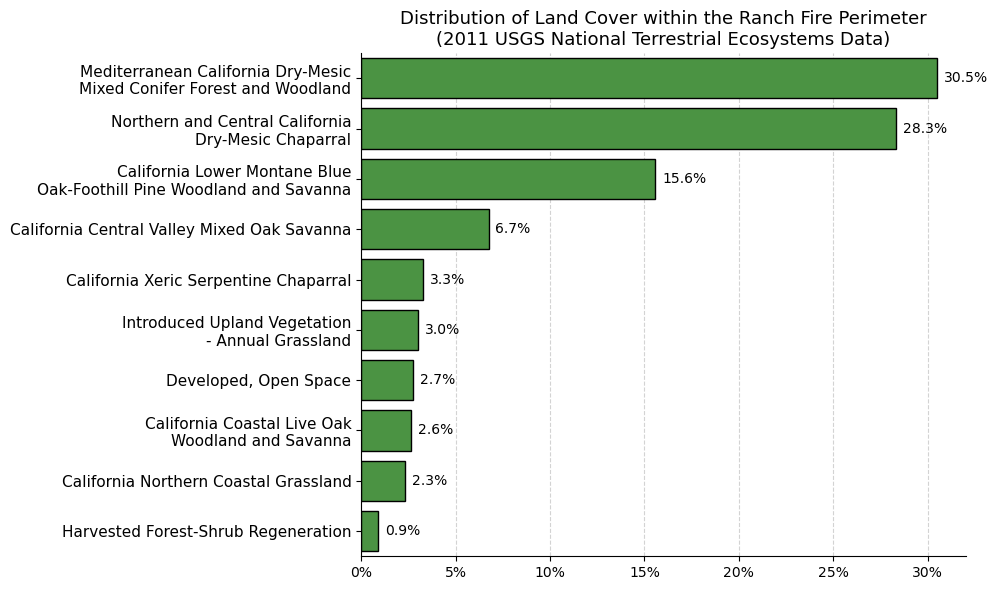

In [19]:
# Plot the land cover statistics
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=valid_classes.head(10), # Only interested in the top 10 most common classes
                y='class_label',  
                x='percentage',
                color='#40A135',
                edgecolor='black',
                orient='h'
                )

# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, padding=5, fmt='%.1f%%')  

# Format x-axis tick labels
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
# Add x-axis gridlines
ax.set_axisbelow(True) # Set below the bars
ax.xaxis.grid(True, which='major', linestyle='--', color='lightgrey')

# Format y-ticks
yticks = list(range(10))  # Added to avoid userwarning setting ytick labels
ax.set_yticks(yticks)
ax.set_yticklabels([
    'Mediterranean California Dry-Mesic\nMixed Conifer Forest and Woodland',
    'Northern and Central California\nDry-Mesic Chaparral',
    'California Lower Montane Blue\nOak-Foothill Pine Woodland and Savanna',
    'California Central Valley Mixed Oak Savanna',
    'California Xeric Serpentine Chaparral',
    'Introduced Upland Vegetation\n- Annual Grassland',
    'Developed, Open Space',
    'California Coastal Live Oak\nWoodland and Savanna',
    'California Northern Coastal Grassland',
    'Harvested Forest-Shrub Regeneration'
])

# Remove plot borders for clarity
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Title and labels
ax.set_title('Distribution of Land Cover within the Ranch Fire Perimeter\n(2011 USGS National Terrestrial Ecosystems Data)', fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('')
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()


In [20]:
# Get the raster resolution in meters
pixel_width = abs(lulc_clip_utm.rio.resolution()[0])
pixel_height = abs(lulc_clip_utm.rio.resolution()[1])
pixel_area = pixel_width * pixel_height

# Convert pixel area from m2 to km2
pixel_area_km2 = pixel_area / 1_000_000 

print(f"Pixel resolution: {pixel_width} x {pixel_height} meters")
print(f"Pixel area: {pixel_area_km2} km2")

Pixel resolution: 32.58366074676054 x 32.58366074676054 meters
Pixel area: 0.0010616949476599839 km2


In [21]:
# Define land cover types to search for
lc_types = ['Woodland', 'Savanna', 'Chaparral', 'Grassland', 'Developed']

# Create summary dataframe
summary_data = []

for lc in lc_types:
    # Filter classes containing the land cover type
    filtered_classes = valid_classes[valid_classes['class_label'].str.contains(lc, case=False, na=False)]
    
    # Calculate totals 
    total_pixels = filtered_classes['pixel_count'].sum()
    total_area = total_pixels * pixel_area_km2
    total_percent = filtered_classes['percentage'].sum()
    
    # Append data
    summary_data.append({
        'land_cover_type': lc,
        'total_percentage': total_percent,
        'total_area_km2': total_area,
        'total_pixels': total_pixels,
        'num_classes': len(filtered_classes)
    })

# Convert to DataFrame and sort
summary_df = pd.DataFrame(summary_data).sort_values('total_percentage', ascending=False)

print("Summary of Land Cover Types:")
print(summary_df)

Summary of Land Cover Types:
  land_cover_type  total_percentage  total_area_km2  total_pixels  num_classes
0        Woodland         51.266380      951.839248        896528           11
2       Chaparral         31.640347      587.451740        553315            3
1         Savanna         25.569259      474.732649        447146            3
3       Grassland          5.792606      107.548637        101299            4
4       Developed          2.663710       49.455874         46582            4


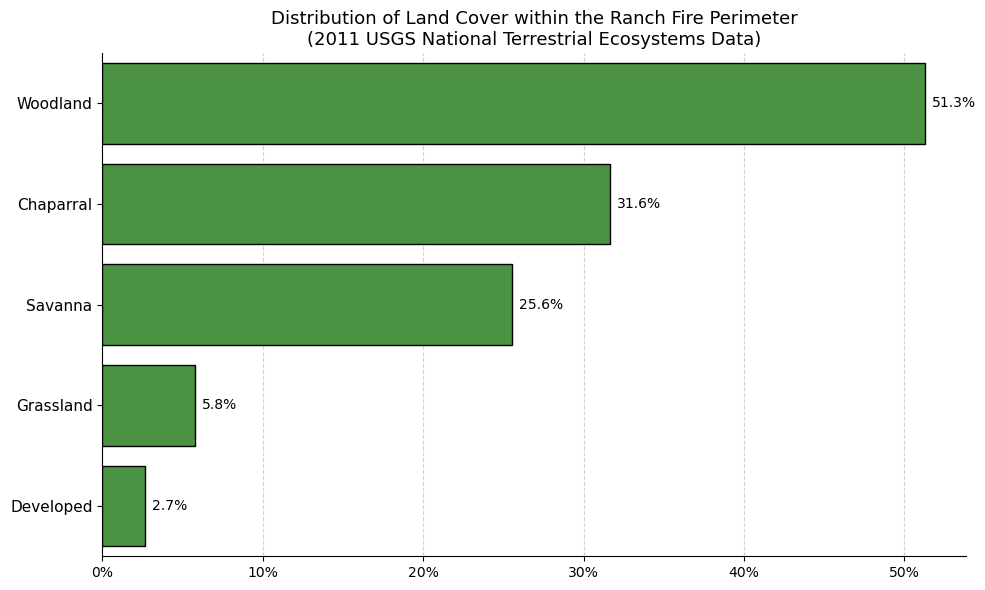

In [ ]:
# Plot the land cover summary statistics
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=summary_df,
                y='land_cover_type',  
                x='total_percentage',
                color='#40A135',
                edgecolor='black',
                orient='h'
                )

# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, padding=5, fmt='%.1f%%')  

# Format x-axis tick labels
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.set_axisbelow(True) # Set below the bars
ax.xaxis.grid(True, which='major', linestyle='--', color='lightgrey')

# Remove plot borders for clarity
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Title and labels
ax.set_title('Distribution of Land Cover within the Ranch Fire Perimeter\n(2011 USGS National Terrestrial Ecosystems Data)', fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('')
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

Now that we've looked at both RBR and Land Cover separately, let's combine these two datasets two understand which vegetation types may be proportionally seeing an increased RBR.

In [59]:
# Check the CRS and shape
print("RBR CRS:", rbr.rio.crs)
print("LULC CRS:", lulc_clipped.rio.crs)

print("RBR shape:", rbr.shape)
print("LULC shape:", lulc_clipped.shape)

# Our shapes don't match, so let's resample the lulc to match the rbr
lulc_resampled = lulc_clipped.rio.reproject_match(rbr, resampling=rasterio.enums.Resampling.nearest)

print("\nAfter resampling:")
print("RBR shape:", rbr.shape)
print("LULC shape:", lulc_resampled.shape)

RBR CRS: EPSG:4326
LULC CRS: EPSG:4326
RBR shape: (1840, 2285)
LULC shape: (1684, 2085)

After resampling:
RBR shape: (1840, 2285)
LULC shape: (1840, 2285)


In [47]:
# Add a final check to ensure things are good before proceeding
assert rbr.rio.crs == lulc_clipped.rio.crs
assert rbr.shape == lulc_resampled.shape

In [48]:
# Convert to DataArrays with consistent coordinates
rbr_values = rbr.values
lulc_values = lulc_resampled.values

# Create masks for valid data (non-NaN RBR and non-zero LULC)
valid_rbr = ~np.isnan(rbr_values)
valid_lulc = lulc_values != 0
combined_mask = valid_rbr & valid_lulc

# Extract valid pixels
rbr_flat = rbr_values[combined_mask]
lulc_flat = lulc_values[combined_mask]

# Create a combined DataFrame
combined_df = pd.DataFrame({
    'rbr': rbr_flat,
    'lulc_code': lulc_flat.astype(int)
})

# Merge with class labels
combined_analysis = pd.merge(combined_df, labels, left_on='lulc_code', right_on='code', how='left')

print(f"Combined dataset has {len(combined_analysis)} valid pixels")
print("Land cover types found:", combined_analysis['class_label'].nunique())

Combined dataset has 4178171 valid pixels
Land cover types found: 40


In [ ]:
# Calculate RBR statistics by land cover type
rbr_by_landcover = combined_analysis.groupby('class_label')['rbr'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(4)

# Add percentage of total area
rbr_by_landcover['percent_of_fire'] = (rbr_by_landcover['count'] / rbr_by_landcover['count'].sum() * 100).round(2)

# Sort by mean RBR (highest severity first)
rbr_by_landcover = rbr_by_landcover.sort_values('mean', ascending=False)

# print("RBR Statistics by Land Cover Type:")
# print(rbr_by_landcover.head(10))

# Filter for land cover types that represent >1% of the fire area
significant_types = rbr_by_landcover[rbr_by_landcover['percent_of_fire'] > 1.0]
# print("\nMajor vegetation types (>1% of fire area):")
# print(significant_types.head(10))

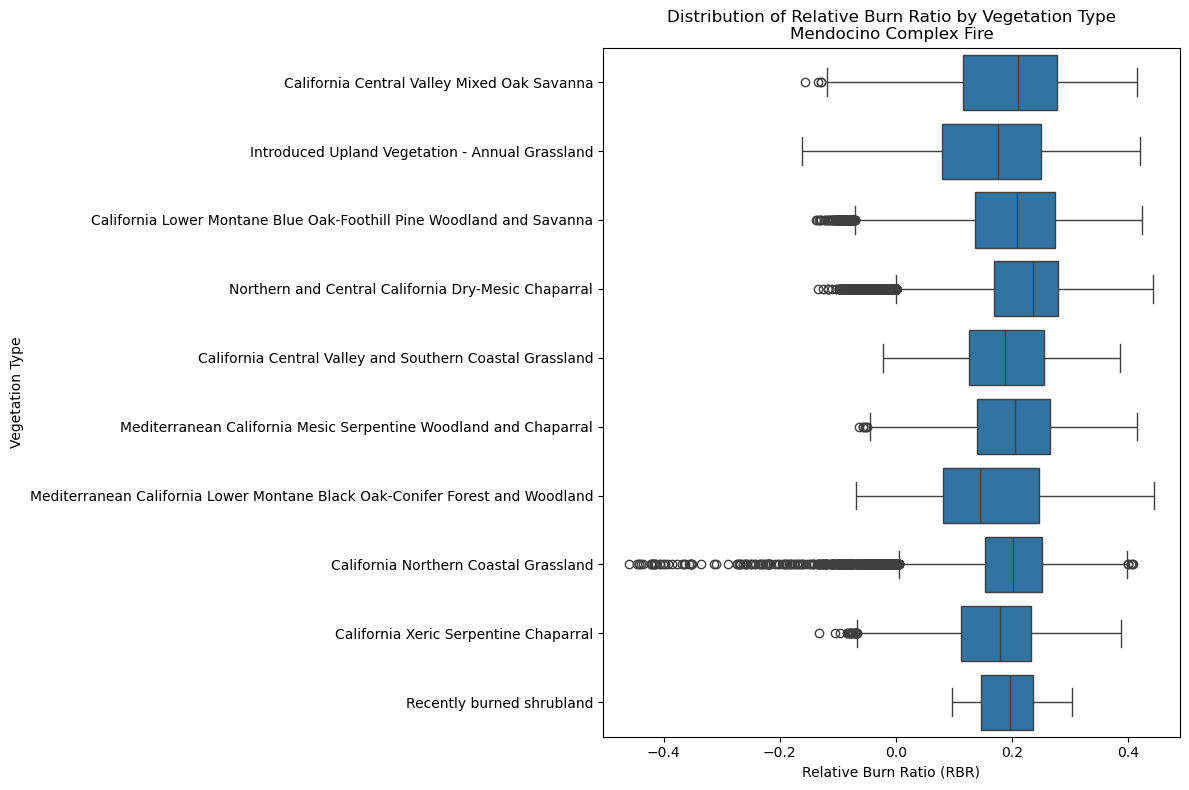

In [ ]:
# Create a boxplot of RBR by major vegetation types
plt.figure(figsize=(12, 8))

# Filter to top 8 most common vegetation types for clarity
top_types = rbr_by_landcover.head(10).index
plot_data = combined_analysis[combined_analysis['class_label'].isin(top_types)]

sns.boxplot(data=plot_data, y='class_label', x='rbr', orient='h')
plt.title('Distribution of Relative Burn Ratio by Vegetation Type\nMendocino Complex Fire')
plt.xlabel('Relative Burn Ratio (RBR)')
plt.ylabel('Vegetation Type')
plt.tight_layout()
plt.show()

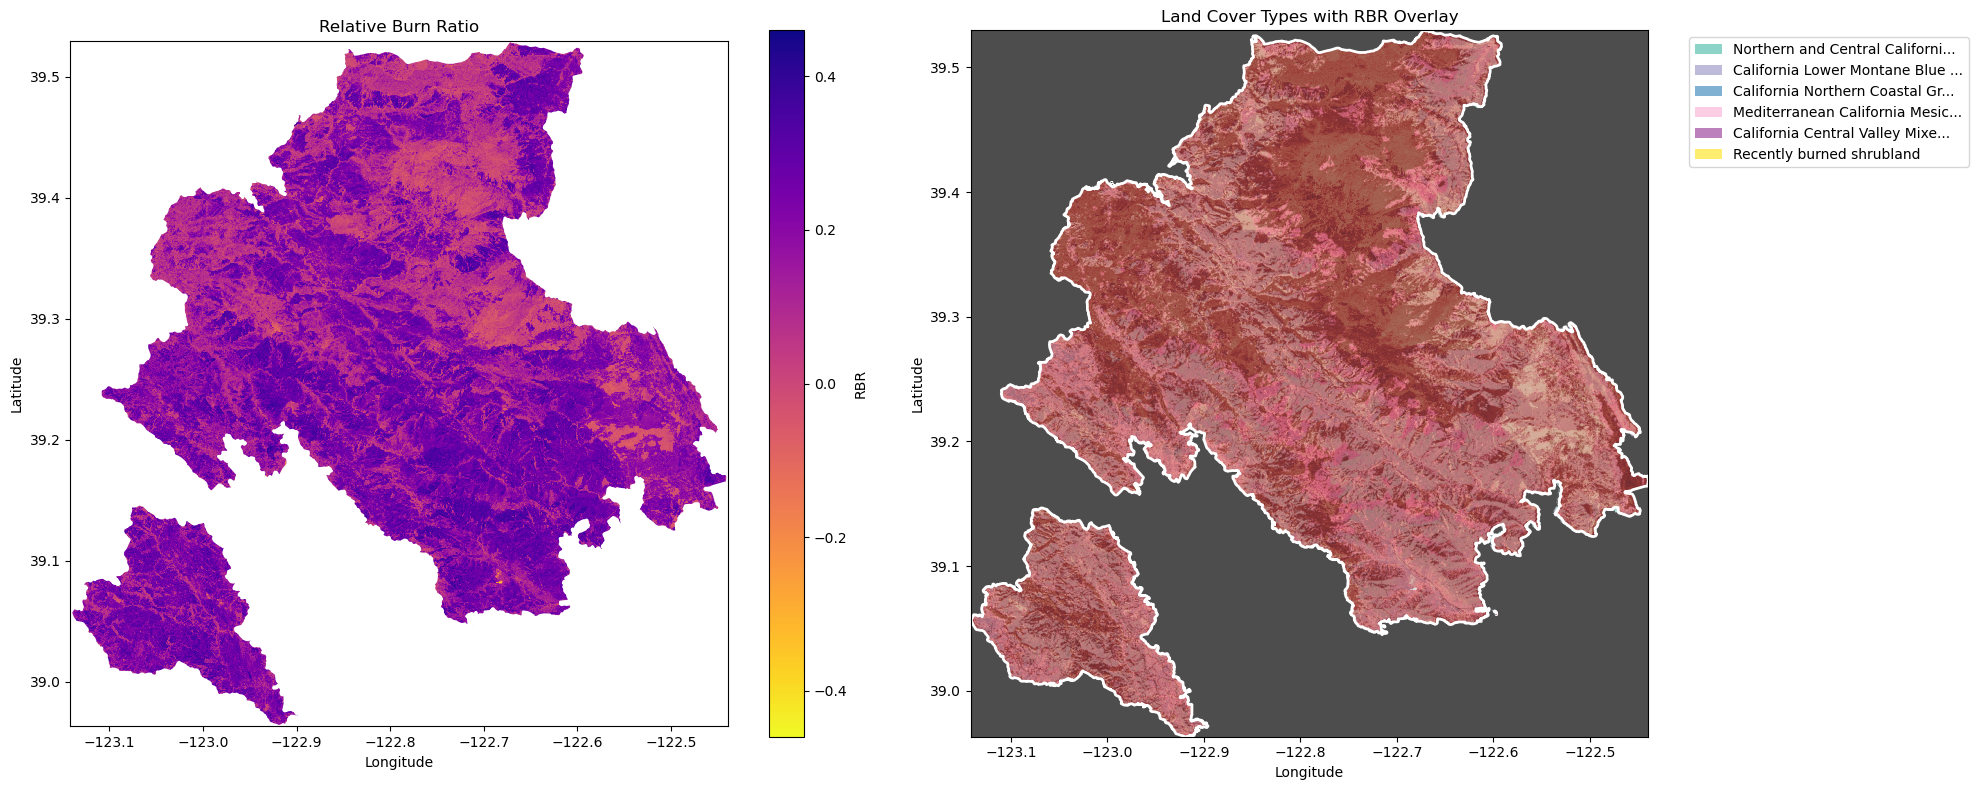

In [51]:
# Create a classified RBR map based on vegetation types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Original RBR
rbr_clipped.plot.imshow(ax=ax1, cmap="plasma_r", 
                       cbar_kwargs={'label': 'RBR'})
mendocino.boundary.plot(ax=ax1, edgecolor='white', linewidth=2)
ax1.set_title('Relative Burn Ratio')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot 2: Land cover with RBR intensity as transparency
# Create a custom colormap for major vegetation types
major_types = rbr_by_landcover.head(6).index
color_map = {}
colors = plt.cm.Set3(np.linspace(0, 1, len(major_types)))

for i, veg_type in enumerate(major_types):
    veg_code = labels[labels['class_label'] == veg_type]['code'].iloc[0]
    color_map[veg_code] = colors[i]

# Create RGB image based on vegetation type
lulc_rgb = np.zeros((*lulc_resampled.shape, 3))
for code, color in color_map.items():
    mask = lulc_resampled.values == code
    lulc_rgb[mask] = color[:3]

# Use RBR as alpha channel (transparency)
rbr_normalized = (rbr_clipped.values - np.nanmin(rbr_clipped.values)) / (np.nanmax(rbr_clipped.values) - np.nanmin(rbr_clipped.values))
rbr_normalized = np.nan_to_num(rbr_normalized, 0)

ax2.imshow(lulc_rgb, extent=[rbr_clipped.x.min(), rbr_clipped.x.max(), 
                            rbr_clipped.y.min(), rbr_clipped.y.max()],
           alpha=0.7)
rbr_clipped.plot.imshow(ax=ax2, cmap="Reds", alpha=0.5, add_colorbar=False)
mendocino.boundary.plot(ax=ax2, edgecolor='white', linewidth=2)

# Add legend for vegetation types
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[labels[labels['class_label'] == vt]['code'].iloc[0]], 
                                label=vt[:30] + '...' if len(vt) > 30 else vt) 
                  for vt in major_types if labels[labels['class_label'] == vt]['code'].iloc[0] in color_map]
ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_title('Land Cover Types with RBR Overlay')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [52]:
# Identify most and least fire-susceptible vegetation types
print("MOST SEVERELY BURNED VEGETATION TYPES:")
print("="*50)
most_severe = rbr_by_landcover.head(3)
for idx, row in most_severe.iterrows():
    print(f"{idx}:")
    print(f"  - Mean RBR: {row['mean']:.3f}")
    print(f"  - Area affected: {row['percent_of_fire']:.1f}% of fire")
    print(f"  - Number of pixels: {row['count']:,}")
    print()

print("LEAST SEVERELY BURNED VEGETATION TYPES:")
print("="*50)
# Filter out types with very small representation
least_severe = rbr_by_landcover[rbr_by_landcover['percent_of_fire'] > 0.5].tail(3)
for idx, row in least_severe.iterrows():
    print(f"{idx}:")
    print(f"  - Mean RBR: {row['mean']:.3f}")
    print(f"  - Area affected: {row['percent_of_fire']:.1f}% of fire")
    print(f"  - Number of pixels: {row['count']:,}")
    print()

# Create a summary table for your analysis
summary_table = rbr_by_landcover[['mean', 'percent_of_fire', 'count']].copy()
summary_table.columns = ['Mean_RBR', 'Percent_of_Fire_Area', 'Pixel_Count']
summary_table.to_csv('data/rbr_by_vegetation_analysis.csv')
print("Summary table saved as 'rbr_by_vegetation_analysis.csv'")

MOST SEVERELY BURNED VEGETATION TYPES:
Northern and Central California Dry-Mesic Chaparral:
  - Mean RBR: 0.215
  - Area affected: 28.3% of fire
  - Number of pixels: 572,251.0

California Lower Montane Blue Oak-Foothill Pine Woodland and Savanna:
  - Mean RBR: 0.201
  - Area affected: 15.5% of fire
  - Number of pixels: 313,904.0

California Northern Coastal Grassland:
  - Mean RBR: 0.199
  - Area affected: 2.3% of fire
  - Number of pixels: 46,780.0

LEAST SEVERELY BURNED VEGETATION TYPES:
Mediterranean California Dry-Mesic Mixed Conifer Forest and Woodland:
  - Mean RBR: 0.137
  - Area affected: 30.5% of fire
  - Number of pixels: 616,164.0

Harvested Forest-Shrub Regeneration:
  - Mean RBR: 0.125
  - Area affected: 0.7% of fire
  - Number of pixels: 14,566.0

Central California Coast Ranges Cliff and Canyon:
  - Mean RBR: 0.041
  - Area affected: 0.7% of fire
  - Number of pixels: 13,070.0

Summary table saved as 'rbr_by_vegetation_analysis.csv'


## Cal-Adapt Climate Data

### Model Selection: LOCA2

Cal-Adapt's catalog has available downscaling techniques: LOCA2 and WRF.

**LOCA2**: Localized Constructed Analogs that use a statistical approach to downscaling large climate models. This uses high resolution local spatial data to "fill in" the gaps of the lower resolution global climate model. 

**WRF**: Weather Research and Forecasting model that uses a dynamic approach to downscaling.

In [ ]:
# Specify search terms to query catalog 
# Select downscaling model
activity_id = ["LOCA2"]

# Select scenarios
experiment_ids = ["historical", "ssp370"]

# Select the time resolution
table_id = ["day"]

# Select the desired model
source_id = ['EC-Earth3-Veg']

In [48]:
# Open connection to the Cal-Adapt data catalog
catalog = intake.open_esm_datastore('https://cadcat.s3.amazonaws.com/cae-collection.json')

# Search through catalog, store results
loca_search = catalog.search(activity_id=activity_id, experiment_id=experiment_ids,
                    table_id=table_id,
                    source_id=source_id)
                    #  institution_id=institution_id)

# Create a data frame
loca_df = loca_search.df

# Plot variables available
print(loca_df.variable_id.unique())
print(loca_df.source_id.unique())

<ArrowExtensionArray>
['hursmax', 'hursmin',    'huss',      'pr',    'rsds',  'tasmax',  'tasmin',
     'uas',     'vas',  'wspeed']
Length: 10, dtype: large_string[pyarrow]
<ArrowExtensionArray>
['EC-Earth3-Veg']
Length: 1, dtype: large_string[pyarrow]


In [ ]:
# Make data frames for our variables of interest
tasmax_df = loca_df[(loca_df["variable_id"] == "tasmax") & (loca_df["variable_id"] == "tasmax")]
uas_df = loca_df[(loca_df["variable_id"] == "uas")] # East-west wind
vas_df = loca_df[(loca_df["variable_id"] == "vas")] # North-south wind

# Extract the unique member ids from each variable
tasmax_mems = tasmax_df.member_id.unique()
uas_mems = uas_df.member_id.unique()
vas_mems = vas_df.member_id.unique()

# Find the common member ids using set, then convert back to a list
common_mems = list(set(tasmax_mems) & set(uas_mems) & set(vas_mems))
common_mems

['r5i1p1f1', 'r2i1p1f1', 'r1i1p1f1', 'r4i1p1f1', 'r3i1p1f1']

As you can see, there are 5 common members shared amongst all three variables. Typically, I would take all 5 members and create an ensemble mean to work with. However, as my laptop is lacking the computing power to effectively complete this task, we will select just one ensemble member.

In [53]:
# Define list of ensemble members
# (in this case there's only one but that might not always be true)
mems = ["r4i1p1f1"]

In [66]:
# Define an empty list
tasmax_hist_proj = []
uas_hist_proj = []
vas_hist_proj = []

# Loop over all common ensemble members 
# leave the loop structure so that we can change to using multiple members if necessary
for mem in range(len(mems)):
    print(mems[mem])

    # Extract historical member of interest
    # max temp
    tasmax_df = loca_df[(loca_df["variable_id"] == "tasmax") 
                        & (loca_df["experiment_id"] == "historical")
                        & (loca_df["member_id"] == mems[mem])]
    # east-west wind
    uas_df = loca_df[(loca_df["variable_id"] == "uas") 
                        & (loca_df["experiment_id"] == "historical")
                        & (loca_df["member_id"] == mems[mem])]
    # north-south wind
    vas_df = loca_df[(loca_df["variable_id"] == "vas") 
                        & (loca_df["experiment_id"] == "historical")
                        & (loca_df["member_id"] == mems[mem])]
    
    # Store historical data as xarray
    hist_tasmax = xr.open_zarr(tasmax_df['path'].iloc[0], storage_options={'anon': True})
    hist_uas = xr.open_zarr(uas_df['path'].iloc[0], storage_options={'anon': True})
    hist_vas = xr.open_zarr(vas_df['path'].iloc[0], storage_options={'anon': True})

    # SSP member of interest
    # max temp
    tasmax_df = loca_df[(loca_df["variable_id"] == "tasmax") 
                        & (loca_df["experiment_id"] == "ssp370")
                        & (loca_df["member_id"] == mems[mem])]
    # east-west wind
    uas_df = loca_df[(loca_df["variable_id"] == "uas") 
                        & (loca_df["experiment_id"] == "ssp370")
                        & (loca_df["member_id"] == mems[mem])]
    # north-south wind
    vas_df = loca_df[(loca_df["variable_id"] == "vas") 
                        & (loca_df["experiment_id"] == "ssp370")
                        & (loca_df["member_id"] == mems[mem])]
    

    # Store ssp 370 data as xarray
    ssp370_tasmax = xr.open_zarr(tasmax_df['path'].iloc[0], storage_options={'anon': True})
    ssp370_uas = xr.open_zarr(uas_df['path'].iloc[0], storage_options={'anon': True})
    ssp370_vas = xr.open_zarr(vas_df['path'].iloc[0], storage_options={'anon': True})
    
    # Concatenate historical and projected information
    tasmax_data = xr.concat([hist_tasmax, ssp370_tasmax], dim="time")
    uas_data = xr.concat([hist_uas, ssp370_uas], dim="time")
    vas_data = xr.concat([hist_vas, ssp370_vas], dim="time")
    
    # Add to list
    tasmax_hist_proj.append(tasmax_data)
    uas_hist_proj.append(uas_data)
    vas_hist_proj.append(vas_data)


r4i1p1f1


In [67]:
# Concatenate the list into a single xarray object
tasmax_hist_proj = xr.concat(tasmax_hist_proj, dim="member")
uas_hist_proj = xr.concat(uas_hist_proj, dim="member")
vas_hist_proj = xr.concat(vas_hist_proj, dim="member")

# Store the member information as values of the new dimension
# tasmax_hist_proj = tasmax_hist_proj.assign_coords(member=("member", mems))
# uas_hist_proj = uas_hist_proj.assign_coords(member=("member", mems))
# vas_hist_proj = vas_hist_proj.assign_coords(member=("member", mems))


In [68]:
# Get data for an earlier period
tasmax_early = tasmax_hist_proj.sel(time=slice("1981-01-01", "2010-12-31")).mean(dim="time")
uas_early = uas_hist_proj.sel(time=slice("1981-01-01", "2010-12-31")).mean(dim="time")
vas_early = vas_hist_proj.sel(time=slice("1981-01-01", "2010-12-31")).mean(dim="time")

# Get data for a later period
tasmax_late = tasmax_hist_proj.sel(time=slice("2071-01-01", "2100-12-31")).mean(dim="time")
uas_late = uas_hist_proj.sel(time=slice("2071-01-01", "2100-12-31")).mean(dim="time")
vas_late = vas_hist_proj.sel(time=slice("2071-01-01", "2100-12-31")).mean(dim="time")

# Calculate the differences
tasmax_diff = tasmax_late - tasmax_early
uas_diff = uas_late - uas_early
vas_diff = vas_late - vas_early

In [71]:
# Extract values as Numpy arrays to make things faster later on
tasmax_vals = tasmax_diff.tasmax.squeeze().values 
uas_vals = uas_diff.uas.squeeze().values
vas_vals = vas_diff.vas.squeeze().values

In [72]:
# Convert from K to degrees C
tasmax_vals = tasmax_vals + 273.15

# Choose step for wind data subsamplings
step = 10 # Every 10th data point

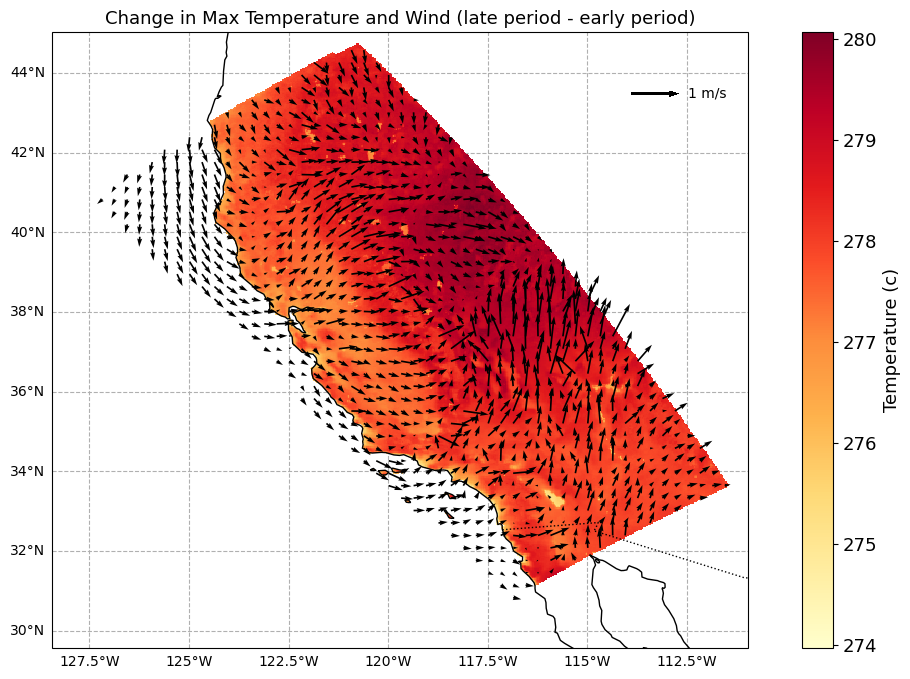

In [73]:
# Create plot and use the map object to specify projection
map = ccrs.PlateCarree() 
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={"projection": map})

# Plot temperature data
plot = ax.pcolormesh(tasmax_diff.lon, tasmax_diff.lat, tasmax_vals, 
                    transform=map, cmap="YlOrRd", zorder=5)
                    # vmin=-1.5, vmax=5)

# Plot uas and vas vectors using quiver
lonvals = tasmax_diff.lon.values
latvals = tasmax_diff.lat.values

wnd = ax.quiver(lonvals[::step], latvals[::step], 
                uas_vals[::step, ::step], vas_vals[::step, ::step],
                transform=map, angles='xy', scale=15, zorder=6)

# Create quiver key for scale
qk = ax.quiverkey(wnd, 0.9, 0.9, 1, label='1 m/s', labelpos='E')

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (c)", fontsize=13)
cbar.ax.tick_params(labelsize=13)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE, zorder=7)
ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=8)

# Add grid lines
ax.set_axisbelow(True) # Set below the bars
gl = ax.gridlines(draw_labels=True, linestyle="--", zorder=0) 
gl.top_labels = False
gl.right_labels = False

# Add title, show plot
ax.set_title("Change in Max Temperature and Wind (late period - early period)", fontsize= 13)
plt.show()